In [23]:
import json
import weaviate
from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO

import random

In [24]:
with open("emojis-en-v13.1.json", "r") as read_file:
    data = json.load(read_file)

emojis = data[0]["emojis"]

In [26]:
client = weaviate.Client('http://localhost:8080/')

schema = {
    'classes': [{
        'class':'Emoji',
        'vectorizer':'img2vec-neural',
        'vectorIndexType':'hnsw',
        'moduleConfig': {
            'img2vec-neural':{
                'imageFields': [
                    'image'
                ]
            }
        },
        'properties':[
            {
                'name':'image',
                'dataType':['blob']
            },
            {
                'name':'emoji',
                'dataType':['string']
            },
            {
                'name':'name',
                'dataType':['string']
            }
        ]
    }]
}

client.schema.create(schema)

UnexpectedStatusCodeException: Create class! Unexpected status code: 422, with response body: {'error': [{'message': 'class name "Emoji" already exists'}]}.

😀 grinning-face


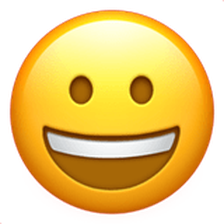

In [19]:
client.batch.configure(
    batch_size=1,
)

def encodeEmoji(emoji_img):
    buffered = BytesIO()
    emoji_img.save(buffered, format="PNG")
    encoded_emoji = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return encoded_emoji

def uploadEmoji(emoji_img,emoji_string,emoji_name):


    emoji_data = {
        'name': emoji_name,
        'image': encodeEmoji(emoji_img),
        'emoji': emoji_string
    }

    client.batch.add_data_object(emoji_data,'Emoji')

def createImage(emoji):
    fnt = ImageFont.truetype("AppleColorEmoji.ttf", 137)
    im = Image.new("RGBA", (160, 160), (255, 0, 0, 0))
    draw = ImageDraw.Draw(im)
    draw.text((0,0), emoji, embedded_color=True, font=fnt)
    im = im.resize((224, 224), Image.LANCZOS)
    return im

emoji = emojis[0]
emoji_string = str(emoji[0][0]) # Get emoji from json file, second index strips extraneous characters
emoji_name = emoji[1].replace(" ","-")
emoji_img = createImage(emoji_string)

print(emoji_string, emoji_name)
display(emoji_img)

uploadEmoji(emoji_img,emoji_string,emoji_name)

In [27]:
client.batch.configure(
    batch_size=12,
)

for emoji in emojis:
    emoji_string = str(emoji[0][0]) # Get emoji from json file, second index strips extraneous characters
    emoji_name = emoji[1].replace(" ","-")
    emoji_img = createImage(emoji_string)
    uploadEmoji(emoji_img,emoji_string,emoji_name)

Query: ☠ skull-and-crossbones
Results:
☠ skull-and-crossbones


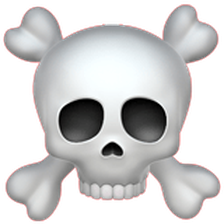

💀 skull


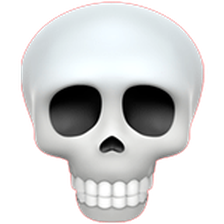

🙉 hear-no-evil-monkey


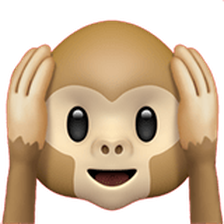

🙊 speak-no-evil-monkey


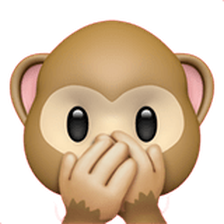

💩 pile-of-poo


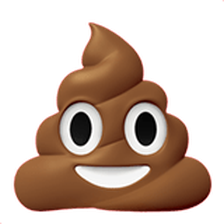

In [28]:
emoji = random.choice(emojis)
emoji_string = str(emoji[0][0]) # Get emoji from json file, second index strips extraneous characters
emoji_name = emoji[1].replace(" ","-")
emoji_img = createImage(emoji_string)

print("Query:",emoji_string,emoji_name)

test = encodeEmoji(emoji_img)

sourceImage = { "image": test}

result = (
    client.query
    .get('Emoji',['name','image','emoji'])
    .with_near_image(sourceImage, encode=False)
    .with_limit(5)
    .do()
)

results = result['data']['Get']['Emoji']

print("Results:")
for emoji in results:
    print(emoji['emoji'], emoji['name'])
    im = Image.open(BytesIO(base64.b64decode(emoji['image'])))
    display(im)